In [1]:
import numpy as np
import matplotlib.pyplot as plt

### 1. Аналитика для оптимальной ориентации аппарата с заданной геометрией на круговой орбите

В предположении двжиения аппарата по круговой орбите с заданным наклонением и ДВУ можно получить, что оптимальный угол поворота пластины относительно оси z орбитальной системы будет вычисляться из следующих условий (нулевой угол -- совпадение нормали к пластине с осью y орбитальной системы):

$ A = (-1) (\sin{u}\cos\Omega + \cos{u}|\cos{i}|\sin\Omega) = \langle \mathbf{x}, \mathbf{e}_x \rangle,$

$ B = |\sin{i}|\sin\Omega  = \langle \mathbf{x}, \mathbf{e}_y \rangle,$

$\phi_{opt} = argmax\{ |f(\phi_1)|, |f(\phi_2)| \}, \quad f(\phi) = -A\sin{\phi} + B\cos{\phi} = -\langle \mathbf{x}, \mathbf{e}_x \rangle\sin{\phi} + \langle \mathbf{x}, \mathbf{e}_y \rangle\cos{\phi},$

$\phi_1 = - \arctan(A/B), \quad \phi_2 = \pi + \phi_1,$

где используется стандарное обозначение для кеплеровых элементов орбиты, $\phi$ -- искомый угол

Теперь учитывая, что $f(\phi_1) = -f(\phi_2)$ можно положить, что любой из углов $\phi_1$ и $\phi_2$ оптимальны

In [2]:
# Расчет оптимального угла поворота для спутника на круговой орбите
# В качестве временной переменно испольуется аргумент широты (u)
# В следующей ячейке ищется угловая скорость

def get_ab(i, omega, u):
    a = (-1) * ( np.sin(u) * np.cos(omega) + np.cos(u) * np.abs(np.cos(i)) * np.sin(omega) )
    b = np.abs(np.sin(i)) * np.sin(omega)
    return a, b

def func(phi, A, B):
    return -A * np.sin(phi) + B * np.cos(phi)

def get_phi(i, omega, u):
    A, B = get_ab(i, omega, u)
    phi1 = np.arctan2(-A , B)  # пластина исходной стороной вверх
    phi2 = np.arctan2(A , -B)  # пластина обратной стороной вверх
    return phi1, phi2

In [3]:
# Расчет угловой скорости исходя из движения по круговой орбите (т.е. u' = 2\pi / T)
def get_u_prime(a, mu):
    return np.sqrt(mu) / np.pow(a, 1.5)

def get_angular_velocity(a, mu, i, omega, u):
    A, B = get_ab(i, omega, u)
    u_pr = get_u_prime(a, mu)
    A_B_sq = (A**2 / B**2)
    A_pr_B = (-1) * u_pr * (np.cos(omega) * np.cos(u) - np.sin(u) * np.sin(omega) * np.abs(np.cos(i)))
    return -A_pr_B / (1 + A_B_sq) * (180 / np.pi)

In [4]:
# Задаем параметры орбита аппарата и центрального тела

mu = 398600.4415                               
a = 6371 + 800                                 
Omega = np.pi / 300
i = (90 - 23.44) * np.pi / 180
nu = np.linspace(0, 2 * np.pi, 500000)         

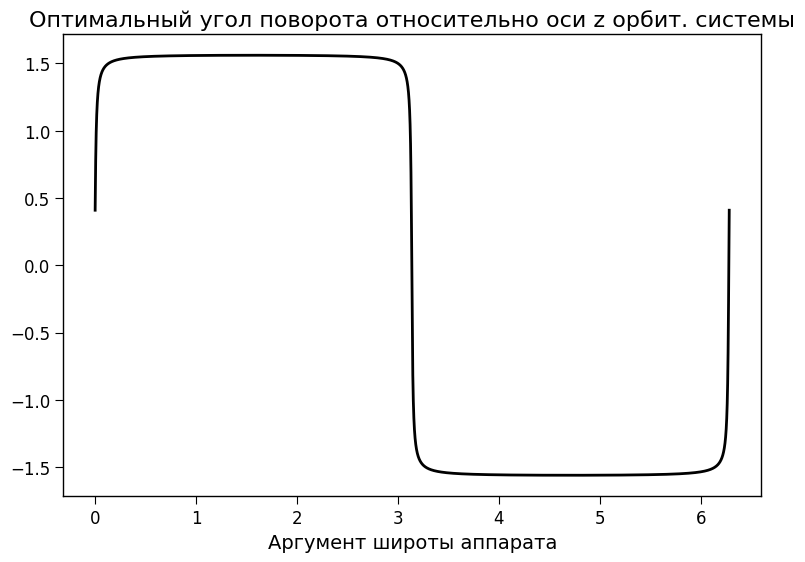

In [5]:
fig, ax = plt.subplots(ncols=1, figsize=(9, 6))
# смотрим на угол
ax.plot(nu, get_phi(i, Omega, nu)[0])
# ax.plot(nu, get_phi(i, Omega, nu)[1])
ax.grid()
ax.set_title("Оптимальный угол поворота относительно оси z орбит. системы")
ax.set_xlabel("Аргумент широты аппарата")

plt.show()

### 2. Реализация аналогичного функционала с помощью poliastro + расчеты кватернинов по заданной орбите

В предположении начальной круговой орбиты расчитаем движение аппарата за один виток вокруг Земли.

In [6]:
from poliastro.twobody import Orbit
from poliastro.bodies import Earth
from astropy import units as u
from pyquaternion import Quaternion
from optimizing import OptimizeSpacecraftOrientation

In [7]:
# сделаем расчет коэффициентов А и В в формулах из первого пункта через модуль Orbit библиотеки poliastro
def get_ab_p(orbit):
    r = orbit.r
    v = orbit.v
    r_cross_v = np.linalg.cross(r, v)
    e_y = r_cross_v / np.linalg.norm(r_cross_v)
    e_x = v / np.linalg.norm(v)
    # так как все это уже задано в некоторой интерциальной системе (в случае с poliastro -- в GCRS), 
    # то считаем за x первый базисный вектор => первые компоненты векторов и дают искомое скалярное произведение
    return e_x[0], e_y[0]

# Здесь важно отметить, что такой расчет работает и для эллиптической орбиты 
# (так как при выводе соотноешний в пункте 1 мы существенно опирались на свойство перпендикулярности скорость и радиус-вектора аппарата) 

# Окончательный расчет с помощью библиотеки
def get_phi_p(orbit):
    A, B = get_ab_p(orbit)
    phi1 = np.arctan2(-A , B)  # пластина исходной стороной вверх
    phi2 = np.arctan2(A , -B)  # пластина обратной стороной вверх
    return phi1, phi2

# Расчет орбитальной системы по положунию и скорости аппарата
def get_orbital_frame_matrix(r, v):
    r_cross_v = np.linalg.cross(r, v)
    e_y = r_cross_v / np.linalg.norm(r_cross_v)
    e_x = v / np.linalg.norm(v)
    return np.array([e_x, e_y, np.linalg.cross(e_x, e_y)]).T

def get_eigen_frame_matrix(e_x, e_y, e_z, phi):
    # собственаая система опирается существенно на орбитальную, так как ориентация аппарата жестко к ней привязана
    t_y = -e_x * np.sin(phi) + e_y * np.cos(phi)
    t_x = np.linalg.cross(t_y, e_z)
    return np.array([t_x, t_y, e_z]).T

# Расчет матрицы перехода из собстсвенной системы аппарата в орбитальную систему
def get_eigen_2_orbital_matrix(r, v, phi):
    # сложим базисные вектора в матрицы переходов
    # эти матрицы задают преобразование поворота векторов из инерциального базиса 
    # в соотвествующий (то есть применяется активная точка зрения)
    orbital_matrix = get_orbital_frame_matrix(r, v)
    eigen_matrix = get_eigen_frame_matrix(orbital_matrix[:, 0], orbital_matrix[:, 1], orbital_matrix[:, 2], phi)
    # расчитаем матрицу перехода из одного базиса в другой
    # эта матрица перехода будет задавать поворот векторов из орбитального базиса в собственный 
    # но кажется, что это тривиальная задача
    transfrom_matrix = orbital_matrix.T @ eigen_matrix
    return transfrom_matrix

# Все описанное здесь будет работать и для произвольной ориентации космического объекта,
# для нашей же конкретной задачи это можно оптимизировать: 
# orbital -> eigen задается просто матрицей поворота вокруг оси e_z, так что нет смысла расчитывать вектора, можно сразу записать преобразование, 
# причем можно сразу посчитать и кватернион перехода   

In [8]:
# Зададим начальную орбиту аппарата
a = (6371 + 800) * u.km                                 
raan = np.pi / 400 * u.rad 
inc = (90 - 23.44) * u.deg
ecc =  0 * u.one
argp = 0 * u.rad

# Расчет оптимального угла в цикле
nus = np.linspace(-np.pi, np.pi, 2000)
phi1 = []
phi2 = []
for nu in nus:
    orbit = Orbit.from_classical(Earth, a, ecc, inc, raan, argp, nu * u.rad)
    result = get_phi_p(orbit)
    phi1.append(result[0].value)
    phi2.append(result[1].value)


/home/evgen/Work/Beurau/test_task/.venv/lib/python3.10/site-packages/astropy/units/decorators.py:313: UserWarning: Wrapping true anomaly to -π <= nu < π
  return_ = wrapped_function(*func_args, **func_kwargs)


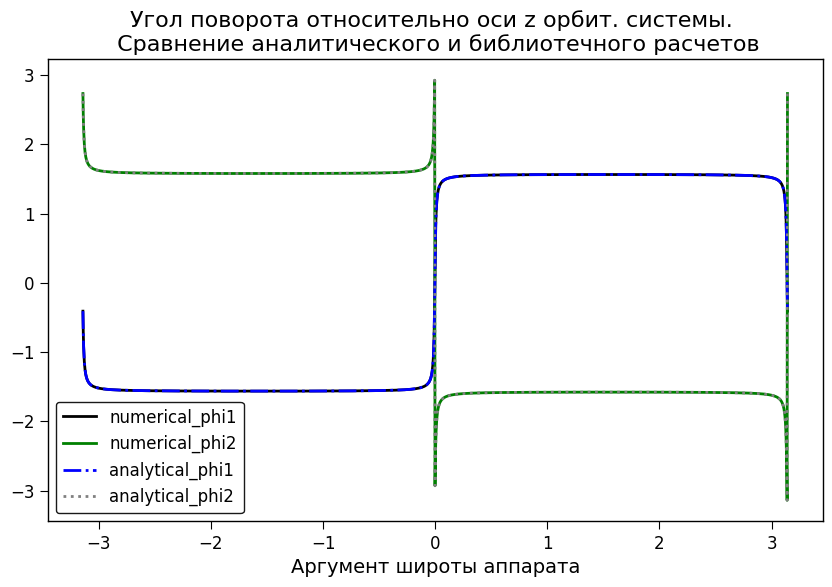

In [9]:
# сравниваем оба подхода
fig, ax = plt.subplots(ncols=1, figsize=(10, 6))
# смотрим на угол
ax.plot(nus, phi1, label='numerical_phi1')
ax.plot(nus, phi2, label='numerical_phi2')
ax.plot(nus, get_phi(inc.value * np.pi / 180, raan.value, nus)[0], label='analytical_phi1')
ax.plot(nus, get_phi(inc.value * np.pi / 180, raan.value, nus)[1], label='analytical_phi2')
ax.grid()
ax.set_title("Угол поворота относительно оси z орбит. системы. \n Сравнение аналитического и библиотечного расчетов")
ax.set_xlabel("Аргумент широты аппарата")
ax.legend()
plt.show()

In [10]:
# Тестирование расчетов матриц перехода (кватернионов сразу)

true_an = 0 * u.rad
phi = (np.pi / 4  - inc.value / 180 * np.pi)
initial_orbit = Orbit.from_classical(Earth, a, ecc, inc, raan, argp, true_an)

o2e = get_eigen_2_orbital_matrix(initial_orbit.r, initial_orbit.v, phi)
i2o = get_orbital_frame_matrix(initial_orbit.r, initial_orbit.v)
i2e = get_eigen_frame_matrix(i2o[:, 0], i2o[:, 1], i2o[:, 2], phi)

q_o2e = Quaternion(matrix=o2e)
q_o2e_an = Quaternion(axis=[0, 0, 1], angle=phi)

q_i2o = Quaternion(matrix=i2o)
q_o2i = q_i2o.inverse   # в параметрах родрига-гамальтона
q_i2e = Quaternion(matrix=i2e) # тоже в параметрах родрига-гамильтона
# кватернион перехода из eigen в orbital в параметрах родрига гамельтона
q_o2e_rg = q_o2i * q_i2e

print(q_o2e)
print(q_o2e_an)
print(q_o2e_rg)

# Проверка совпадения поворотов, задаваемых кватернионами
print(q_o2e == q_o2e_an or q_o2e == -q_o2e_an)
print(q_o2e == -q_o2e_rg or q_o2e == q_o2e_rg)
print(q_o2e_rg == -q_o2e_an or q_o2e_rg == q_o2e_an)

# на всякий случай убедимся на случайном векторе
rand_vec = np.random.random(3)
print( "Разница в повороте случайного вектора: ", np.linalg.norm( q_o2e.rotate(rand_vec) - q_o2e_rg.rotate(rand_vec) ) )

# Тестирование расчета угла между нормально и осью x инерциальной системы (тест работает только если raan = np.pi / 2)
analytical_result = (np.pi / 2  - inc.value / 180 * np.pi) - phi
calculated_angle_sun_norm = np.arccos(q_i2e.rotate(np.array([0, 1, 0]))[0])
print("Calculated value: ", calculated_angle_sun_norm * u.rad, "Analytical value: ", analytical_result * u.rad, "Diff: ", np.abs(calculated_angle_sun_norm - analytical_result))

0.982 +0.000i -0.000j -0.187k
0.982 -0.000i -0.000j -0.187k
0.982 +0.000i -0.000j -0.187k
True
True
True
Разница в повороте случайного вектора:  4.839349969133127e-16
Calculated value:  1.5652427516703564 rad Analytical value:  0.7853981633974483 rad Diff:  0.7798445882729081
